In [1]:
from __future__ import print_function
import sys
sys.setrecursionlimit(99999)
import pdb

import numpy as np
np.random.seed(1337)  # for reproducibility

import keras

from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import ZeroPadding2D, AveragePooling2D, MaxPooling2D, Convolution2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization

from keras import backend as K
K.set_image_dim_ordering('th') #use theano as backend

batch_size = 40
nb_classes = 1
nb_epochs = 100

Using TensorFlow backend.


In [2]:
from keras.layers import Input, merge
from keras.models import Model
import pdb

def building_residual_block(input_shape, n_feature_maps, kernel_sizes=None, n_skip=2, is_subsample=False, subsample=None):
    '''
    [1] Building block of layers for residual learning.
        Code based on https://github.com/ndronen/modeling/blob/master/modeling/residual.py
        , but modification of (perhaps) incorrect relu(f)+x thing and it's for conv layer
    [2] ----This comment used to be valid. Now it is not, but I failed to track since when.----
        ----Now the comment below is incorrect, I am using strided convolution here.----
        ----invalid comment------------------------------------------------------------------------------
        | MaxPooling is used instead of strided convolution to make it easier                           | 
        | to set size(output of short-cut) == size(output of conv-layers).                              | 
        | If you want to remove MaxPooling,                                                             | 
        |    i) change (border_mode in Convolution2D in shortcut), 'same'-->'valid'                     | 
        |    ii) uncomment ZeroPadding2D in conv layers.                                                | 
        |        (Then the following Conv2D is not the first layer of this container anymore,           | 
        |         so you can remove the input_shape in the line 101, the line with comment #'OPTION' )  | 
        -------------------------------------------------------------------------------------------------
    [3] It can be used for both cases whether it subsamples or not.
    [4] In the short-cut connection, I used 1x1 convolution to increase #channel.
        It occurs when is_expand_channels == True 
    input_shape = (None, num_channel, height, width) 
    n_feature_maps: number of feature maps. In ResidualNet it increases whenever image is downsampled.
    kernel_sizes : list or tuple, (3,3) or [3,3] for example
    n_skip       : number of layers to skip
    is_subsample : If it is True, the layers subsamples by *subsample* to reduce the size.
    subsample    : tuple, (2,2) or (1,2) for example. Used only if is_subsample==True
    '''
    # ***** VERBOSE_PART ***** 
    print ('   - New residual block with')
    print ('      input shape:', input_shape)
    print ('      kernel size:', kernel_sizes)
    # is_expand_channels == True when num_channels increases.
    #    E.g. the very first residual block (e.g. 1->64, 3->128, 128->256, ...)
    is_expand_channels = not (input_shape[0] == n_feature_maps) 
    if is_expand_channels:
        print ('      - Input channels: %d ---> num feature maps on out: %d' % (input_shape[0], n_feature_maps))
    if is_subsample:
        print ('      - with subsample:', subsample)
    kernel_row, kernel_col = kernel_sizes
    # set input
    x = Input(shape=(input_shape))
    # ***** SHORTCUT PATH *****
    if is_subsample: # subsample (+ channel expansion if needed)
        shortcut_y = Convolution2D(n_feature_maps, (kernel_sizes[0], kernel_sizes[1]), 
                                    subsample=subsample,
                                    padding='same')(x)
        print('POOLED11111!!!!!',shortcut_y.get_shape())
    else: # channel expansion only (e.g. the very first layer of the whole networks)
        if is_expand_channels:
            shortcut_y = Convolution2D(n_feature_maps, (1, 1), padding='same')(x)
        else:
            # if no subsample and no channel expension, there's nothing to add on the shortcut.
            shortcut_y = x
    # ***** CONVOLUTION_PATH ***** 
    conv_y = x
    for i in range(n_skip):
        conv_y = BatchNormalization(axis=1)(conv_y)        
        conv_y = Activation('elu')(conv_y)
        if i==1 and is_subsample: # [Subsample at layer 1 if needed]
            conv_y = Convolution2D(n_feature_maps, (kernel_row, kernel_col),
                                    subsample=subsample,
                                    padding='same')(conv_y)
            print('POOLED222222!!!!!',conv_y.get_shape())
        else:        
            conv_y = Convolution2D(n_feature_maps, (kernel_row, kernel_col), padding='same')(conv_y)
    # output
    y = merge([shortcut_y, conv_y], mode='sum')
    block = Model(input=x, output=y)
    print ('        -- model was built.')
    return block

In [5]:
def compute_padding_length(length_before, stride, length_conv):
    ''' Assumption: you want the subsampled result has a length of floor(original_length/stride).
    '''
    N = length_before
    F = length_conv
    S = stride
    if S == F:
        return 0
    if S == 1:
        return (F-1)/2
    for P in range(S):
        if (N-F+2*P)/S + 1 == N/S:
            return P
    return None

def design_for_residual_blocks(num_channel_input=1):
    ''''''
    model = Sequential() # it's a CONTAINER, not MODEL
    # set numbers
    num_big_blocks = 5
    image_patch_sizes = [[3,3]]*num_big_blocks
    pool_sizes = [(2,2)]*num_big_blocks
    n_features =      [24, 48, 96, 128, 128]
    n_features_next = [48, 96, 128, 128, 256]
    height_input = 128
    width_input  = 128
    for conv_idx in range(num_big_blocks):    
        n_feat_here = n_features[conv_idx]
        # residual block 0
        model.add(building_residual_block( (num_channel_input, height_input, width_input),
                                            n_feat_here,
                                            kernel_sizes=image_patch_sizes[conv_idx]
                                            ))

        # residual block 1 (you can add it as you want (and your resources allow..))
        if False:
            print('add another block')
            model.add(building_residual_block( (n_feat_here, height_input, width_input),
                                                n_feat_here,
                                                kernel_sizes=image_patch_sizes[conv_idx]
                                                ))
        
        # the last residual block N-1
        # the last one : pad zeros, subsamples, and increase #channels
        pad_height = compute_padding_length(height_input, pool_sizes[conv_idx][0], image_patch_sizes[conv_idx][0])
        print('pad_height=',pad_height)
        pad_width = compute_padding_length(width_input, pool_sizes[conv_idx][1], image_patch_sizes[conv_idx][1])
        print('pad_width=',pad_width)
        model.add(ZeroPadding2D(padding=(pad_height,pad_width))) 
        height_input += 2*pad_height
        width_input += 2*pad_width
        n_feat_next = n_features_next[conv_idx]
        model.add(building_residual_block( (n_feat_here, height_input, width_input),
                                            n_feat_next,
                                            kernel_sizes=image_patch_sizes[conv_idx],
                                            is_subsample=True,
                                            subsample=pool_sizes[conv_idx]
                                            ))

        height_input, width_input = model.output_shape[2:]
        print('height=',height_input)
        print('width=',width_input)
        # width_input  = int(width_input/pool_sizes[conv_idx][1])
        num_channel_input = n_feat_next

    # Add average pooling at the end:
    print('Average pooling, from (%d,%d) to (1,1)' % (height_input, width_input))
    model.add(AveragePooling2D(pool_size=(height_input, width_input)))

    return model

def get_residual_model(is_mnist=True, img_channels=1, img_rows=28, img_cols=28):
    model = keras.models.Sequential()
    first_layer_channel = 24
    if is_mnist: # size to be changed to 32,32
        # model.add(ZeroPadding2D((2,2), input_shape=(img_channels, img_rows, img_cols))) # resize (28,28)-->(32,32)
        # the first conv 
        model.add(Convolution2D(first_layer_channel, (6, 6), padding='same', 
                                input_shape=(img_channels, img_rows, img_cols)))
    else:
        model.add(Convolution2D(first_layer_channel, (6, 6), padding='same', 
                                input_shape=(img_channels, img_rows, img_cols)))

    model.add(Activation('elu'))
    # [residual-based Conv layers]
    residual_blocks = design_for_residual_blocks(num_channel_input=first_layer_channel)
    model.add(residual_blocks)
    model.add(BatchNormalization(axis=1))
    model.add(Activation('elu'))
    # [Classifier]    
    model.add(Flatten())
    model.add(Dense(nb_classes*100))
    model.add(Activation('elu'))
    # model.add(Dense(nb_classes*10))
    model.add(Dense(nb_classes))
    model.add(Activation('linear'))
    # [END]
    return model

In [6]:
if __name__ =='__main__':
    
    is_mnist = True
    is_cifar10 = not is_mnist
    if is_mnist:
        import scipy.io as sio
        import numpy as np
        img_rows, img_cols = 128, 128
        img_channels = 1

        # Training data, shuffled and split
        WB = np.array(sio.loadmat('sandstone_data.mat')['Data'])
        Y_data = np.array(sio.loadmat('sandstone_data.mat')['L'])
        X_data = np.reshape(WB,(768,1,img_rows,img_cols))

        X_train = X_data[:720]
        X_val = X_data[720:]
        
        WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
        X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
        Y_test = sio.loadmat('test_sandstone_data.mat')['L']
        
        label_norm = np.concatenate((Y_data, Y_test), axis=0)
        label_norm = (label_norm-min(label_norm))/(max(label_norm)-min(label_norm))
        Y_train = label_norm[:720]
        Y_val = label_norm[720:-240]
        Y_test = label_norm[-240:]

        print(' == Sandstone ==')

    else:
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        img_rows, img_cols = 32, 32
        img_channels = 3
        print(' == CIFAR10 ==')

    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')

    #X_train = (X_train - np.mean(X_train))/np.std(X_train)
    #X_test = (X_test - np.mean(X_test))/np.std(X_test)

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_val.shape[0], 'validation samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    # Y_train = np_utils.to_categorical(y_train, nb_classes)
    # Y_test = np_utils.to_categorical(y_test, nb_classes)

    model = get_residual_model(is_mnist=is_mnist, img_channels=img_channels, img_rows=img_rows, img_cols=img_cols)

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    #     # autosave best Model
    #     best_model_file = "./my_model_weights.h5"
    #     best_model = ModelCheckpoint(best_model_file, verbose=1, save_best_only=True)

    from keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=1, validation_data=(X_val, Y_val), callbacks=[early_stop])

 == Sandstone ==
X_train shape: (720, 1, 128, 128)
720 train samples
48 validation samples
240 test samples
   - New residual block with
      input shape: (24, 128, 128)
      kernel size: [3, 3]


/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/hechaoli/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("me..., inputs=Tensor("in...)`
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same", strides=(2, 2))`


        -- model was built.
pad_height= 1
pad_width= 1
   - New residual block with
      input shape: (24, 130, 130)
      kernel size: [3, 3]
      - Input channels: 24 ---> num feature maps on out: 48
      - with subsample: (2, 2)
POOLED11111!!!!! (?, 48, 65, 65)


/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same", strides=(2, 2))`


POOLED222222!!!!! (?, 48, 65, 65)
        -- model was built.
height= 65
width= 65
   - New residual block with
      input shape: (48, 65, 65)
      kernel size: [3, 3]
        -- model was built.
pad_height= 0
pad_width= 0
   - New residual block with
      input shape: (48, 65, 65)
      kernel size: [3, 3]
      - Input channels: 48 ---> num feature maps on out: 96
      - with subsample: (2, 2)
POOLED11111!!!!! (?, 96, 33, 33)


/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same", strides=(2, 2))`
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same", strides=(2, 2))`


POOLED222222!!!!! (?, 96, 33, 33)
        -- model was built.
height= 33
width= 33
   - New residual block with
      input shape: (96, 33, 33)
      kernel size: [3, 3]
        -- model was built.
pad_height= 0
pad_width= 0
   - New residual block with
      input shape: (96, 33, 33)
      kernel size: [3, 3]
      - Input channels: 96 ---> num feature maps on out: 128
      - with subsample: (2, 2)
POOLED11111!!!!! (?, 128, 17, 17)
POOLED222222!!!!! (?, 128, 17, 17)
        -- model was built.


/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", strides=(2, 2))`
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", strides=(2, 2))`


height= 17
width= 17
   - New residual block with
      input shape: (128, 17, 17)
      kernel size: [3, 3]
        -- model was built.
pad_height= 0
pad_width= 0
   - New residual block with
      input shape: (128, 17, 17)
      kernel size: [3, 3]
      - with subsample: (2, 2)
POOLED11111!!!!! (?, 128, 9, 9)
POOLED222222!!!!! (?, 128, 9, 9)
        -- model was built.
height= 9
width= 9
   - New residual block with
      input shape: (128, 9, 9)
      kernel size: [3, 3]
        -- model was built.
pad_height= 0
pad_width= 0
   - New residual block with
      input shape: (128, 9, 9)
      kernel size: [3, 3]
      - Input channels: 128 ---> num feature maps on out: 256
      - with subsample: (2, 2)
POOLED11111!!!!! (?, 256, 5, 5)


/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same", strides=(2, 2))`
/home/hechaoli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same", strides=(2, 2))`


POOLED222222!!!!! (?, 256, 5, 5)
        -- model was built.
height= 5
width= 5
Average pooling, from (5,5) to (1,1)
Train on 720 samples, validate on 48 samples
Epoch 1/100
720/720 [==============================] - 830s - loss: 3.4341 - mean_absolute_error: 0.8760 - val_loss: 143.3915 - val_mean_absolute_error: 11.3841
Epoch 2/100
720/720 [==============================] - 800s - loss: 0.0543 - mean_absolute_error: 0.1916 - val_loss: 3.5552 - val_mean_absolute_error: 1.8499
Epoch 3/100
720/720 [==============================] - 800s - loss: 0.0191 - mean_absolute_error: 0.1118 - val_loss: 0.4018 - val_mean_absolute_error: 0.6304
Epoch 4/100
720/720 [==============================] - 800s - loss: 0.0084 - mean_absolute_error: 0.0736 - val_loss: 0.1046 - val_mean_absolute_error: 0.3019
Epoch 5/100
720/720 [==============================] - 800s - loss: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0900 - val_mean_absolute_error: 0.2864
Epoch 6/100
720/720 [========================

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 128, 128)      888       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 128, 128)      0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 256, 1, 1)         3016096   
_________________________________________________________________
batch_normalization_21 (Batc (None, 256, 1, 1)         1024      
_________________________________________________________________
activation_23 (Activation)   (None, 256, 1, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
__________

training mse: 0.011051792522
testing mse: 0.0137092405008


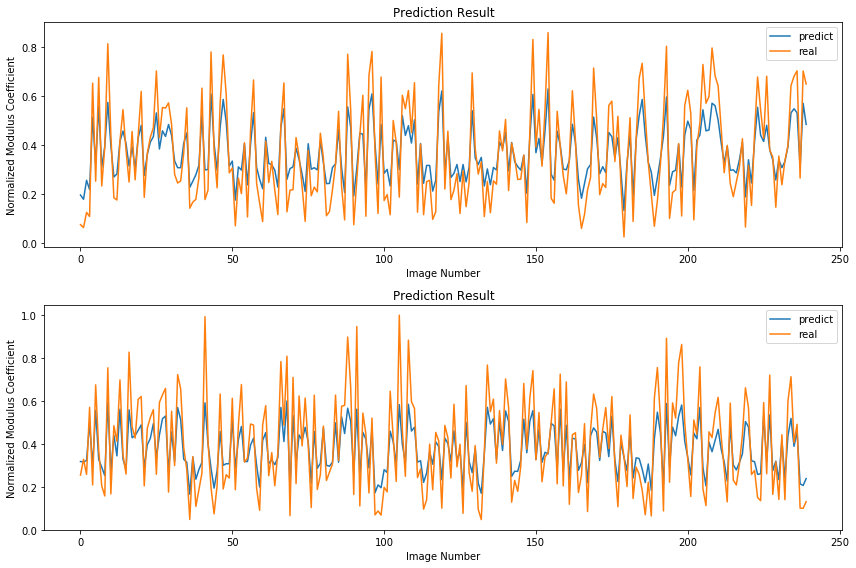

In [8]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline


x=[]
num = 240
for i in range(num):
    x.append(i)

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(2,1,1)

train_pred=model.predict(X_train)
print('training mse:', mean_squared_error(Y_train, train_pred))

ax1.plot(x,train_pred[0:num], label='predict')
ax1.plot(x,Y_train[0:num],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')


ax2=fig.add_subplot(2,1,2)

test_pred=model.predict(X_test)
print('testing mse:', mean_squared_error(Y_test, test_pred))

ax2.plot(x,test_pred[0:num], label='predict')
ax2.plot(x,Y_test[0:num],label='real')
plt.legend()
ax2.set_title('Prediction Result')
ax2.set_xlabel('Image Number')
ax2.set_ylabel('Normalized Modulus Coefficient')

plt.tight_layout()

In [16]:
print(np.mean(np.square(Y_test.reshape(-1)-pred.reshape(-1)))) #mean squared error
print(np.mean(np.abs(Y_test.reshape(-1)-pred.reshape(-1))))    #mean absolute error

0.0088689665837
0.0754638759538


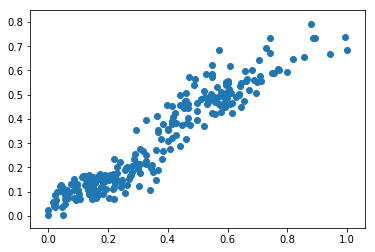

In [17]:
plt.scatter(Y_test.reshape(-1),pred)

In [18]:
from keras.models import load_model
model.save('resnet_model_61917.h5')